In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from scipy import stats
import seaborn as sns
import pandas as pd

from scipy.stats import zscore

from numpy.random import multivariate_normal
from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"

# Load data and Gaussian mixture model

In [2]:
with open('{}/468202_len128_s2_4cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
# with open('../../../data_GRS1915/468202_len128_s2_4cad_errors_errorfix.pkl', 'rb') as f:
#     segments_errors = pickle.load(f)
# with open('../../../data_GRS1915/468202_len128_s2_4cad_ids_errorfix.pkl', 'rb') as f:
#     id_per_seg = pickle.load(f)

weights_dir = "../../../model_weights/model_2020-04-29_09-12-23.h5"
segments_dir = '../../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])

with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)
    
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature


desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
# desc_stats[:,0] = np.median(segments_counts, axis=1).flatten()
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# desc_GM = np.hstack((zscore(desc_stats, axis=0), GMM_bics))

shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [71]:
with open("{}/reconstructions_from_model_2020-04-29_09-12-23.pkl".format(data_dir), 'rb') as f: # output of LSTM autoencoder's decoder
    segment_reconstructions = pickle.load(f)

In [4]:
with open("{}/shape16_moments4_components114_alldata.pkl".format(data_dir), 'rb') as f: # 114 component Gausssian mixture model fit to the 468202 20d samples
    clf_GM114 = pickle.load(f)

/export/data/jakubok/software/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
/export/data/jakubok/software/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.19.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
with open('{}/shape_moments_GM114_labels.pkl'.format(data_dir), 'rb') as f:
    shape_moments_GM114_labels = pickle.load(f)

In [5]:
# shape_moments_GM114_proba = clf_GM114.predict_proba(shape_moments)
# with open('{}/shape_moments_GM114_proba.pkl'.format(data_dir), 'wb') as f:
#     pickle.dump(shape_moments_GM114_proba, f)

In [ ]:
# with open('{}/shape_moments_GM114_proba.pkl'.format(data_dir), 'rb') as f:
#     shape_moments_GM114_proba = pickle.load(f)

# Comparison 114 components vs Belloni classifications

In [7]:
# load observation classifications from Huppenkothen 2017
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state
        
        
# load IDs of segmented light curves: observationsID_segmentIndex
with open('{}/468202_len128_s2_4cad_ids_errorfix.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)

        
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
segment_class = []
for ob in seg_ObIDs:
    if ob in ob_state:
        segment_class.append(ob_state[ob])
    else:
        segment_class.append("Unknown")

In [10]:
new_classification = shape_moments_GM114_labels

Belloni_classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega", "Unknown"])

comparison_matrix = np.zeros((len(np.unique(new_classification)), len(Belloni_classes)), dtype=int)

comparison_matrix_df = pd.DataFrame(comparison_matrix, columns=Belloni_classes, index=np.unique(new_classification))

for n_Bc, Belloni_class in enumerate(Belloni_classes):
    Belloni_class_indices = np.where(np.array(segment_class) == Belloni_class)[0]
    count_clusters_for_class = np.unique(np.take(new_classification, Belloni_class_indices), return_counts=True)
    for cluster_ind, cluster in enumerate(count_clusters_for_class[0]):
        comparison_matrix_df[Belloni_class][cluster] = count_clusters_for_class[1][cluster_ind]

In [154]:
class_normalized_comparison_matrix_df=(comparison_matrix_df-comparison_matrix_df.min())/(comparison_matrix_df.max()-comparison_matrix_df.min())
known_comparison_matrix_df = comparison_matrix_df.drop(columns=['Unknown']).T
component_normalized_comparison_matrix_df = (known_comparison_matrix_df-known_comparison_matrix_df.min())/(known_comparison_matrix_df.max()-known_comparison_matrix_df.min())

In [214]:
# find particularly well defined classes

for classes in ["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"]:
    major_comps = []
    count_below0p1 = 0

    for i,v in class_normalized_comparison_matrix_df["{}".format(classes)].sort_values(ascending=False).items():
        if v>0.3:
            major_comps.append((i,np.round(v, decimals=2)))
        elif v>0.0:
            count_below0p1+=1
#     print(major_comps)
    print(classes, "\tNo above 0.3: ", len(major_comps), "\tNo below 0.3: ", count_below0p1)

alpha 	No above 0.3:  8 	No below 0.3:  38
beta 	No above 0.3:  8 	No below 0.3:  36
gamma 	No above 0.3:  2 	No below 0.3:  23
delta 	No above 0.3:  7 	No below 0.3:  23
theta 	No above 0.3:  12 	No below 0.3:  34
kappa 	No above 0.3:  3 	No below 0.3:  18
lambda 	No above 0.3:  8 	No below 0.3:  16
mu 	No above 0.3:  1 	No below 0.3:  17
nu 	No above 0.3:  6 	No below 0.3:  32
rho 	No above 0.3:  12 	No below 0.3:  19
phi 	No above 0.3:  9 	No below 0.3:  26
chi 	No above 0.3:  5 	No below 0.3:  41
eta 	No above 0.3:  4 	No below 0.3:  27
omega 	No above 0.3:  3 	No below 0.3:  7


In [227]:
n=0

In [386]:
# find particularly class-homogeneous components

good_comps = {}
for comp in range(114):
    comp_counts = comparison_matrix_df.iloc[comp,:].sort_values(ascending=False)
    comp_counts_nonzero = comp_counts.where(comp_counts>0).dropna().astype(int)
    if comp_counts_nonzero.index[0] == "Unknown":
        comp_class_proportion = comp_counts_nonzero[1:]/comp_counts_nonzero[1:].sum()
        if comp_class_proportion[0]>0.999:
            good_comps[comp] = comp_counts_nonzero
    else:
        good_comps[comp] = comp_counts_nonzero
print(len(good_comps))
# dominated_comps = []
# for i,v in good_comps.items():
#     if v.index[1] == "chi":
#         dominated_comps.append(i)
# print(dominated_comps)

26


In [351]:
# chi is >95% bar unknowns : (10), 3, 5, 7, 15, 24, 28, 37, 44, 53, 57, 60, 69, 76, 91, 103, 112
# kappa : (79),  4, 42, 78, 104 (87 has 90.8% kappa)
# theta : 25, 26, 71
# lambda : 66
# rho : 12, 18, 19, 20, 22, 23, 30, 38, 45, 49, 50, 54, 56, 63, 65, 74, 77, 86, 97, 107

print(comp_list)

[10, 79]


In [363]:
comparison_matrix_df.iloc[79]#/(comparison_matrix_df.iloc[87].sum()-2628)

alpha         0
beta          0
gamma         0
delta         0
theta         0
kappa      1860
lambda        0
mu            0
nu            0
rho           0
phi           0
chi           0
eta           0
omega         0
Unknown    1782
Name: 79, dtype: int64

In [382]:
comp_list = []
for i,v in good_comps.items():
    if len(v)>1:
        comp_list.append(i)

In [383]:
print(comp_list)

[3, 5, 7, 10, 18, 19, 22, 24, 26, 37, 38, 42, 44, 45, 49, 53, 54, 56, 60, 63, 65, 66, 69, 74, 76, 79, 86, 91, 97, 103, 104, 107, 112]


In [287]:
comp_counts = comparison_matrix_df.iloc[7,:].sort_values(ascending=False)
comp_counts_nonzero = comp_counts.where(comp_counts>0).dropna().astype(int)
comp_counts_nonzero[1:]/comp_counts_nonzero[1:].sum()

chi    0.999686
phi    0.000314
Name: 7, dtype: float64

In [208]:
comparison_matrix_df.sum(axis=0)

alpha        2739
beta         6058
gamma        6588
delta        3268
theta        8532
kappa        4970
lambda       1792
mu           2942
nu           2131
rho          6846
phi          4131
chi         35739
eta          1774
omega         738
Unknown    379954
dtype: int64

In [152]:
comparison_matrix_df.T.iloc[:,66]

alpha        0
beta         0
gamma        0
delta        0
theta        0
kappa        0
lambda     268
mu           0
nu           0
rho          0
phi          0
chi          0
eta          0
omega        0
Unknown    459
Name: 66, dtype: int64

In [145]:
(0.002524/1.002524)*7617

19.176905490541873

In [144]:
np.unique(shape_moments_GM114_labels, return_counts=True)[1][10]

7617

In [134]:
np.where(comparison_matrix_df.T.idxmax().values != "Unknown")

(array([10, 79]),)

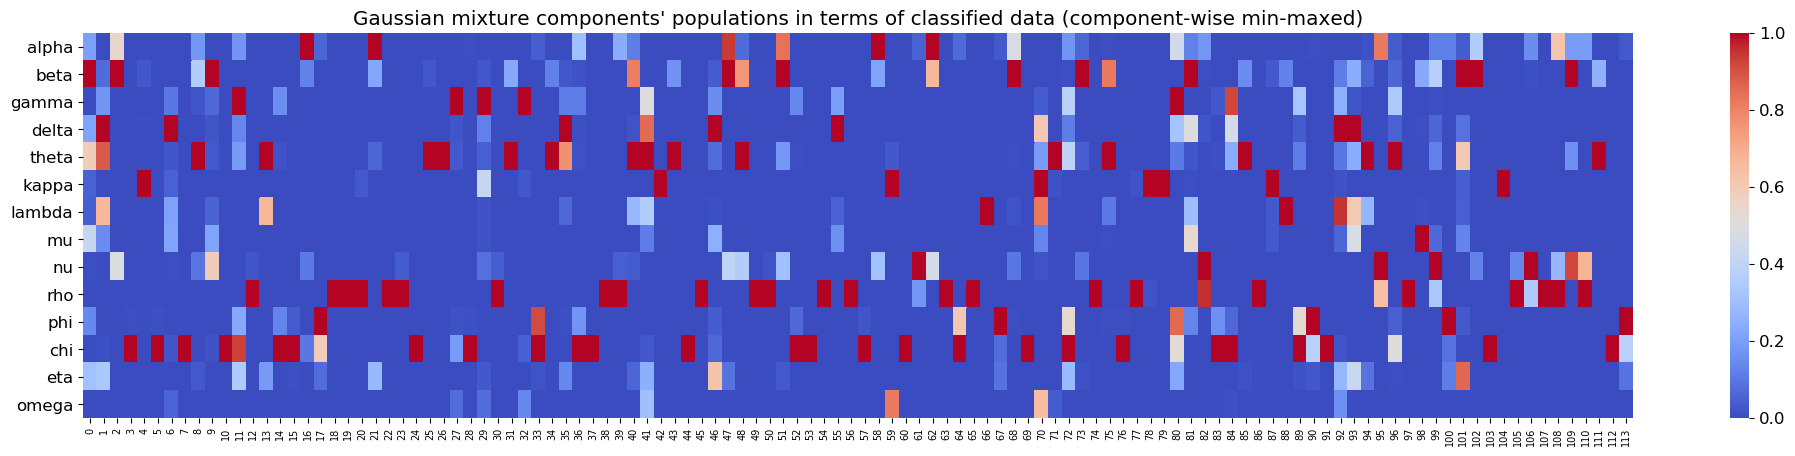

In [133]:
plt.rcParams['figure.figsize'] = (25.0, 5.0)


ax = sns.heatmap(component_normalized_comparison_matrix_df, xticklabels=True, yticklabels=True, cmap='coolwarm')#, linewidth=0.5)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 7)
plt.title("Gaussian mixture components' populations in terms of classified data (component-wise min-maxed)")
plt.show()

In [69]:
[i for i,v in normalized_comparison_matrix_df["beta"].sort_values(ascending=False)[:10].items() if v>=0.5]

[81, 73]

In [65]:
[i for i,v in normalized_comparison_matrix_df["Unknown"].sort_values(ascending=False)[:10].items()]

[112, 7, 60, 28, 57, 64, 52, 5, 37, 36]

In [93]:
[i for i,v in normalized_comparison_matrix_df["delta"].sort_values(ascending=False)[:10].items() if v>=0.5]

[46, 81, 6]

In [109]:
normalized_comparison_matrix_df["eta"].sort_values(ascending=False)[:10]

46     1.000000
101    0.822943
93     0.316708
72     0.304239
11     0.289277
21     0.204489
80     0.189526
100    0.174564
0      0.169576
67     0.149626
Name: eta, dtype: float64

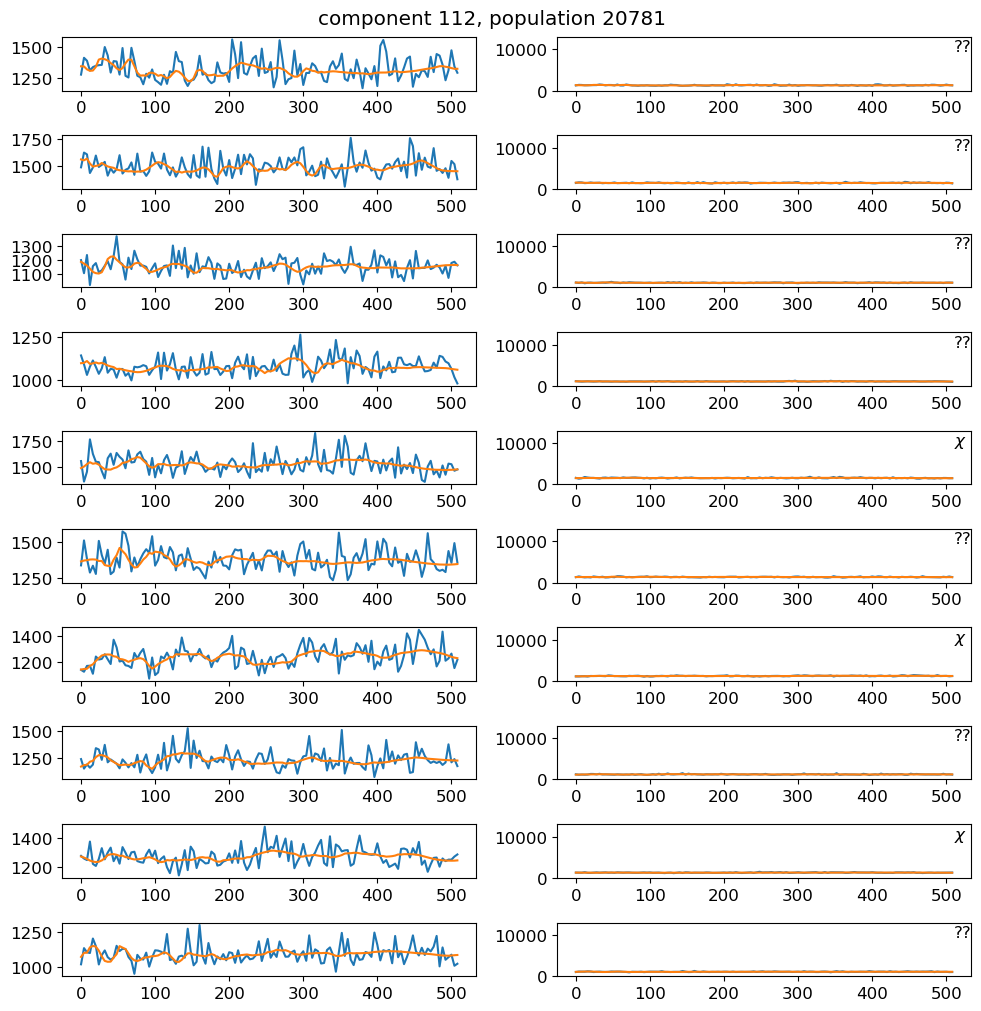

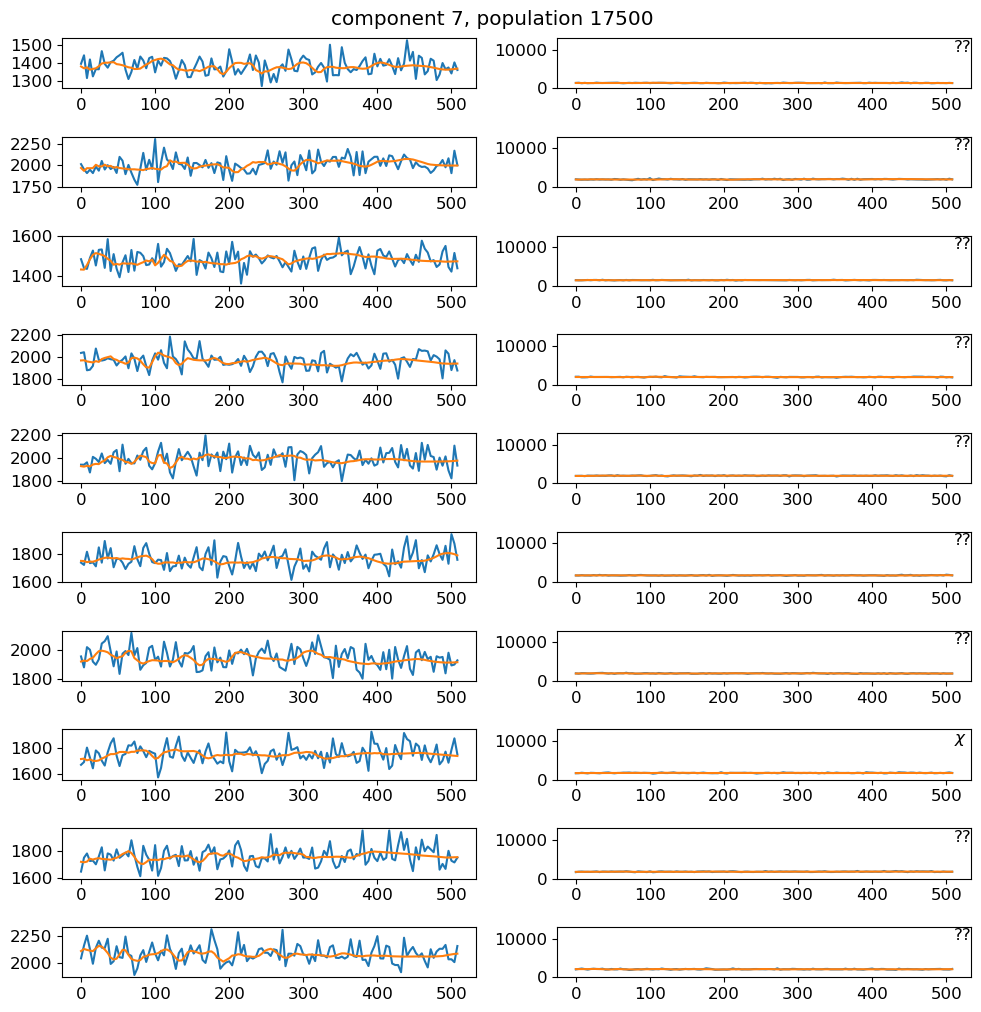

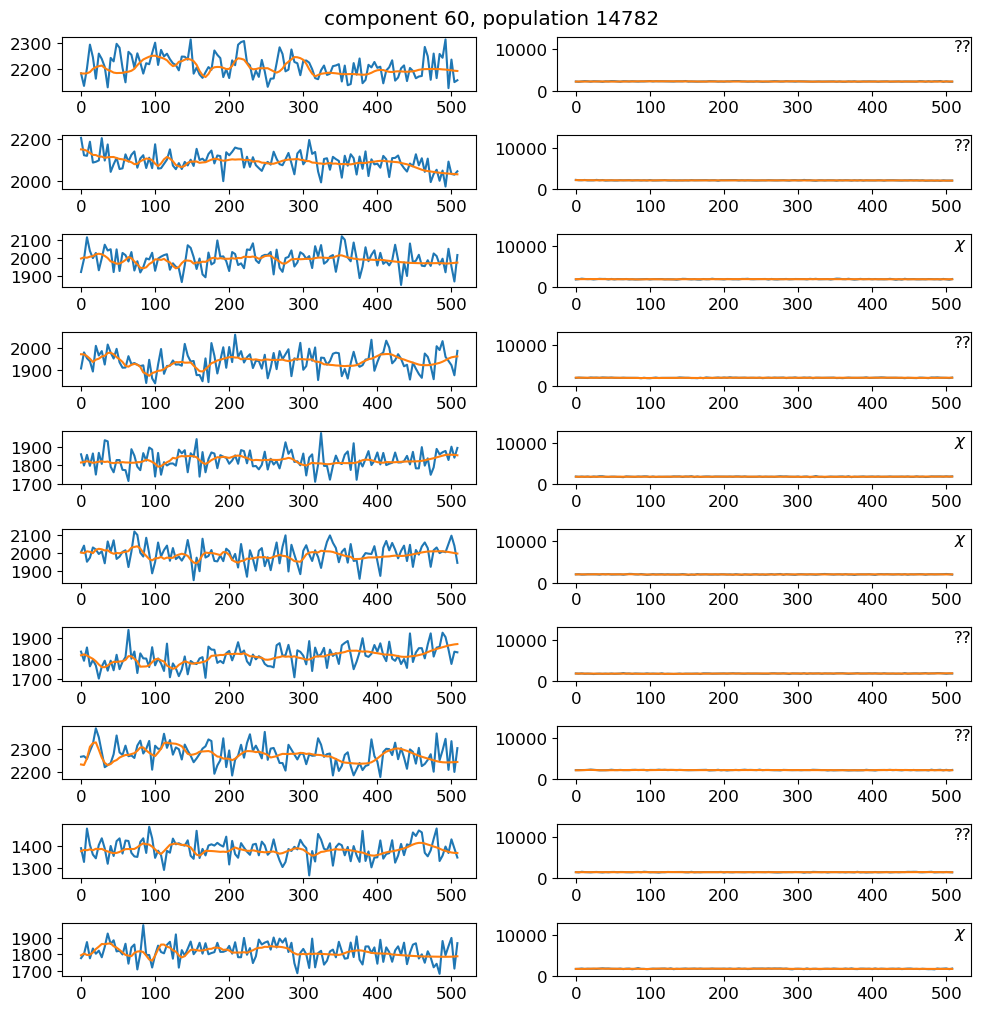

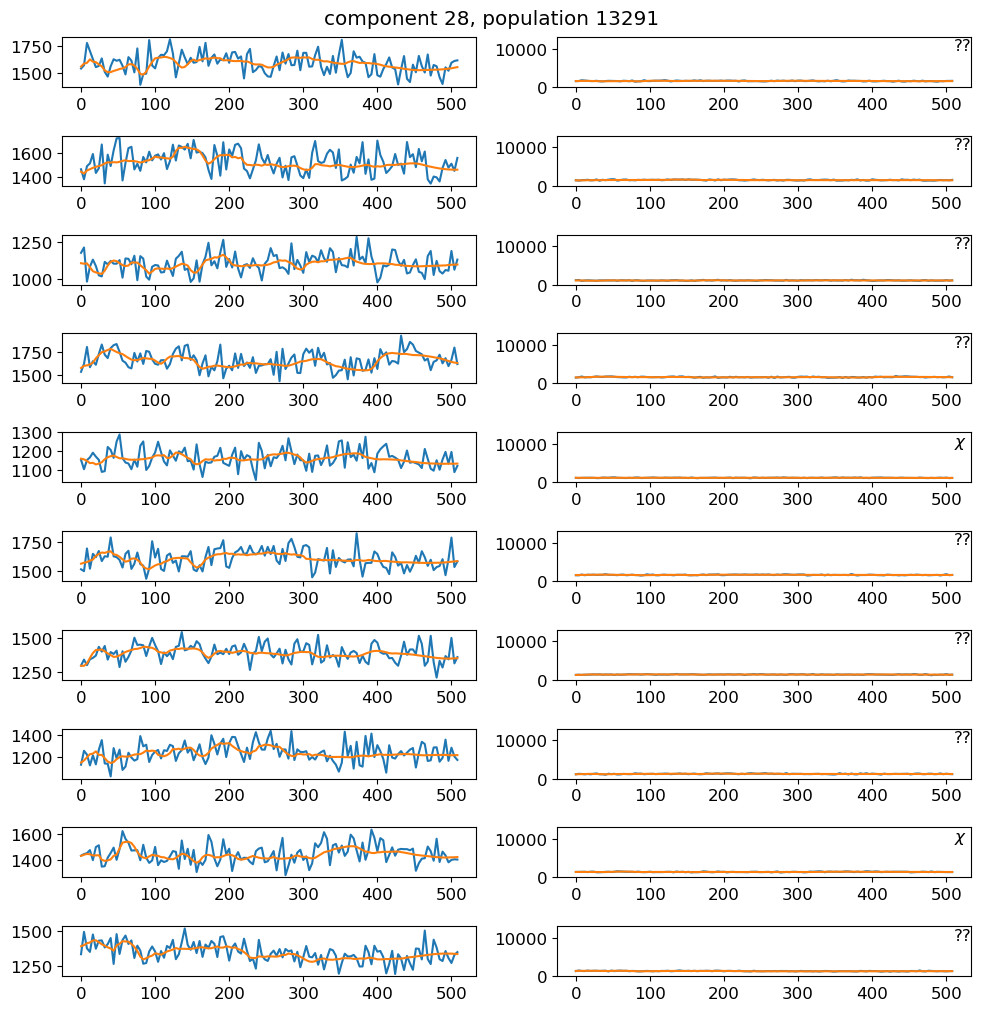

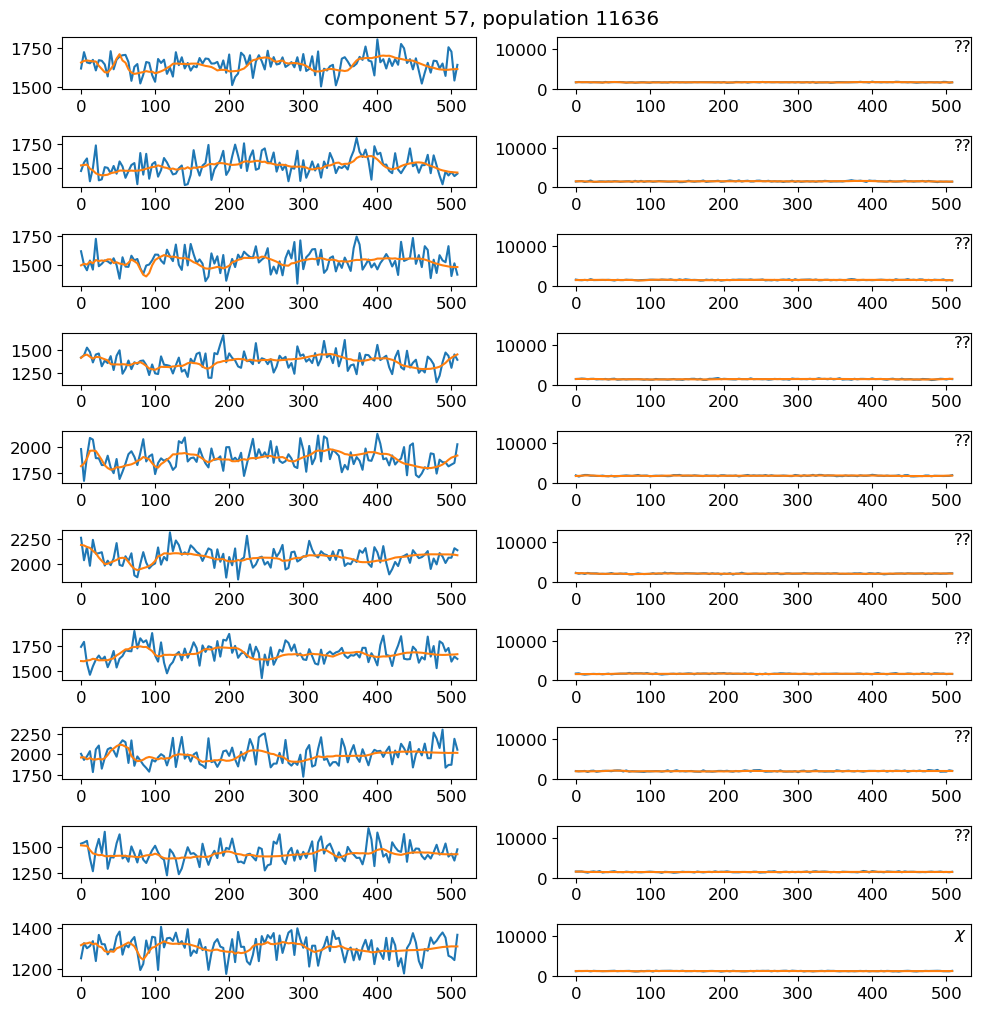

In [111]:
plt.close()

counts_todo = [i for i,v in normalized_comparison_matrix_df["Unknown"].sort_values(ascending=False)[:10].items() if v>=0.5]

if len(counts_todo) > 3:
    how_many_to_plot = 10
else:
    how_many_to_plot = 20

plt.rcParams['figure.figsize'] = (10,how_many_to_plot)
plt.rcParams.update({'font.size': 12})

counts = np.unique(shape_moments_GM114_labels, return_counts=1)

for ind, new_class in enumerate(counts[0][np.argsort(counts[1])[::-1]]):
    if new_class not in counts_todo: continue
    class_segments = np.where(shape_moments_GM114_labels == new_class)[0]
    fig, axes = plt.subplots(nrows=how_many_to_plot, ncols=2)
    
    for subplot in range(how_many_to_plot):
        data = segments_counts[class_segments[subplot]]
        reconstruction = segment_reconstructions[class_segments[subplot]]
        class_name = segment_class[class_segments[subplot]]
        axes[subplot, 0].plot(np.array(list(range(128)))*4,segments_counts[class_segments[subplot]])#, c="green", linewidth=0.5, zorder=-5)
        axes[subplot, 0].plot(np.array(list(range(128)))*4, reconstruction*np.std(data)+np.mean(data))
        axes[subplot, 1].plot(np.array(list(range(128)))*4,segments_counts[class_segments[subplot]])
        axes[subplot, 1].plot(np.array(list(range(128)))*4, reconstruction*np.std(data)+np.mean(data))
        axes[subplot, 1].set_ylim([0, 13000])
        if class_name == "Unknown": 
            class_name = "??"
        else:
            class_name = r"$\{}$".format(class_name)
        axes[subplot, 1].text(x=510, y=9500, s=class_name)
    plt.suptitle("component {}, population {}".format(new_class, np.sort(counts[1])[::-1][ind]), y=1.01)
    plt.tight_layout()
    plt.show()


# Hierarchical clustering of the observations based on constituent components

In [446]:
# make a dictorionary that groups indices of segments of the same observation 
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

In [470]:
# sanity check
bad_keys = []
for k,v in ObID_SegIndices_dict.items():
    if not all(np.take(np.array(seg_ObIDs), v) == k):
        bad_keys.append(k)
print(bad_keys)

[]


In [475]:
# make a dictionary of Gaussian component indices instead of segment indices  
ObID_GaussComps_dict = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict[ObID] = [shape_moments_GM114_labels[ind] for ind in Indices]

In [480]:
obs_component_counts_df = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict),len(np.unique(shape_moments_GM114_labels)))), index=np.unique(seg_ObIDs), columns=list(range(114)))

In [501]:
for ObID, GaussComps in ObID_GaussComps_dict.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df.loc[ObID][comp_id] = comp_count

In [517]:
from sklearn.preprocessing import Normalizer
normalized_obs_component_counts_df = pd.DataFrame(Normalizer(norm='max').fit_transform(obs_component_counts_df), index=np.unique(seg_ObIDs), columns=list(range(114)))

In [518]:
normalized_obs_component_counts_df

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
10258-01-01-00,0.0,0.0,0.0,0.115023,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009390
10258-01-02-00,0.0,0.0,0.0,0.175355,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014218
10258-01-03-00,0.0,0.0,0.0,0.089445,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10258-01-04-00,0.0,0.0,0.0,0.017380,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001337
10258-01-05-00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96701-01-50-01,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
96701-01-51-00,0.0,0.0,0.0,0.026316,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
96701-01-51-01,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
96701-01-52-00,0.0,0.0,0.0,0.274194,0.0,0.000000,0.0,0.016129,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [521]:
from sklearn.cluster import AgglomerativeClustering

hclustering = AgglomerativeClustering(affinity='euclidean', linkage='ward')

In [522]:
hclustering.fit(normalized_obs_component_counts_df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

In [514]:
from sklearn.preprocessing import Normalizer
normalized_obs_component_counts_df = Normalizer(norm='max').fit_transform(obs_component_counts_df)

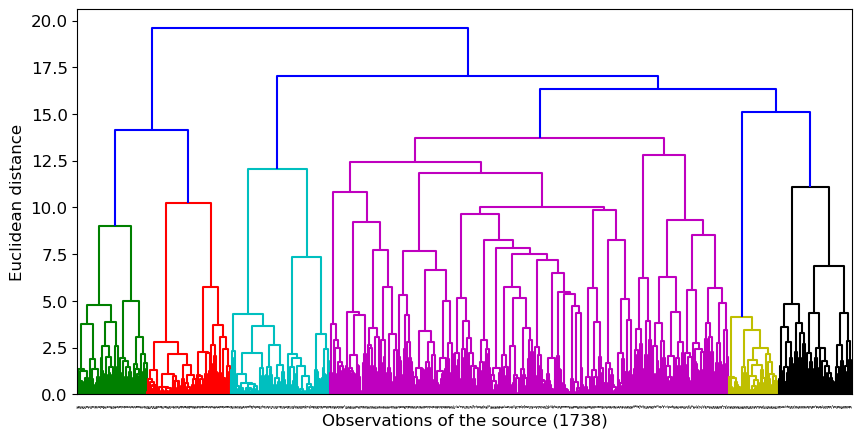

In [555]:
import scipy.cluster.hierarchy as sch
plt.rcParams['figure.figsize'] = [10,5]
linkage = sch.linkage(normalized_obs_component_counts_df, method="ward")
dendrogram = sch.dendrogram(linkage, truncate_mode=None, p=2, leaf_font_size = 0)
plt.ylabel("Euclidean distance")
plt.xlabel("Observations of the source (1738)")
plt.show()

In [560]:
state_ob

NameError: name 'state_ob' is not defined

In [ ]:
# make a dictorionary that groups indices of segments of the same observation 
state_ob = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

In [554]:
normalized_obs_component_counts_df

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
10258-01-01-00,0.0,0.0,0.0,0.115023,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009390
10258-01-02-00,0.0,0.0,0.0,0.175355,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014218
10258-01-03-00,0.0,0.0,0.0,0.089445,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10258-01-04-00,0.0,0.0,0.0,0.017380,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001337
10258-01-05-00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96701-01-50-01,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
96701-01-51-00,0.0,0.0,0.0,0.026316,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
96701-01-51-01,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
96701-01-52-00,0.0,0.0,0.0,0.274194,0.0,0.000000,0.0,0.016129,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [581]:
from scipy.cluster.hierarchy import fcluster
dist_agglo_cluster_matrix = np.zeros((1738, 200))
dist_no_clusters = []
for dist_ind, distance in enumerate(np.linspace(0,18,200)):
    clusters = fcluster(linkage, distance, criterion='distance')
    dist_no_clusters.append((distance, len(np.unique(clusters))))
    dist_agglo_cluster_matrix[:, dist_ind] = clusters

In [583]:
fcluster(linkage, 12.84422110552764, criterion='distance')

array([3, 3, 3, ..., 3, 3, 7], dtype=int32)

In [590]:
Belloni_classes.shape

(15,)

In [595]:
obs_classes = []
obs_classes_ind = []
for ob in np.unique(seg_ObIDs):
    if ob in ob_state.keys():
        obs_classes.append(ob_state[ob])
        obs_classes_ind.append(np.where(np.array(Belloni_classes) == ob_state[ob])[0][0])
    else:
        obs_classes.append("Unknown")
        obs_classes_ind.append(14)

In [596]:
obs_classes_ind

[14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 6,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 7,
 1,
 10,
 10,
 14,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 10,
 10,
 3,
 14,
 3,
 3,
 10,
 10,
 10,
 10,
 10,
 1,
 14,
 14,
 11,
 11,
 14,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 7,
 7,
 7,
 14,
 14,
 8,
 8,
 11,
 11,
 8,
 11,
 14,
 14,
 14,
 14,
 14,
 4,
 14,
 4,
 14,
 4,
 14,
 4,
 11,
 14,
 14,
 14,
 11,
 14,
 14,
 14,
 14,
 0,
 0,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 9,
 11,
 11,
 14,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 14,
 11,
 0,
 0,
 11,
 11,
 14,
 11,
 11,
 0,
 11,
 9,
 11,
 0,
 11,
 9,
 14,
 0,
 9,
 9,
 9,
 9,
 9,
 5,
 9,
 5,
 6,
 6,
 2,
 6,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 14,
 3,
 3,
 14,
 1,
 14,
 7,
 4,
 1,
 1,
 14,
 11,
 11,
 11,
 11,
 14,
 11,
 11,
 14,
 1,
 1,
 1,
 7,
 14,
 3,
 2,
 2,
 2,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 

In [606]:
np.unique(fcluster(linkage, 12.84422110552764, criterion='distance'))

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

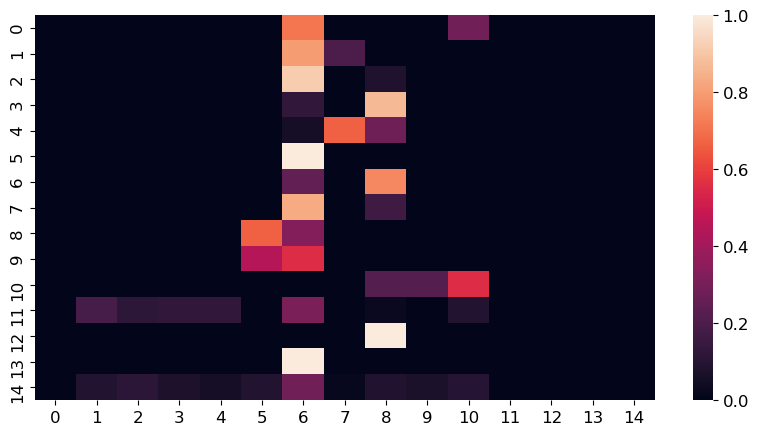

In [612]:
from sklearn.metrics import confusion_matrix

cf_mx = confusion_matrix(obs_classes_ind, fcluster(linkage, 11.939698492462313, criterion='distance'), normalize="true")
sns.heatmap(cf_mx)
plt.show()

In [609]:
Belloni_classes

array(['alpha', 'beta', 'gamma', 'delta', 'theta', 'kappa', 'lambda',
       'mu', 'nu', 'rho', 'phi', 'chi', 'eta', 'omega', 'Unknown'],
      dtype='<U7')

In [587]:
obs_classes

['Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'lambda',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'mu',
 'beta',
 'phi',
 'phi',
 'Unknown',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'theta',
 'theta',
 'theta',
 'theta',
 'theta',
 'theta',
 'theta',
 'theta',
 'theta',
 'theta',
 'delta',
 'phi',
 'phi',
 'delta',
 'Unknown',
 'delta',
 'delta',
 'phi',
 'phi',
 'phi',
 'phi',
 'phi',
 'beta',
 'Unknown',
 'Unknown',
 'chi',
 'chi',
 'Unknown',
 'chi',
 'chi',
 'chi',
 'chi',
 'chi',
 'chi',
 'chi',
 'chi',
 'chi',
 'chi',
 'mu',
 'mu',
 'mu',
 'Unknown',
 'Unknown',
 'nu',
 'nu',
 'chi',
 'chi',
 'nu',
 'chi',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'theta',
 'Unknown',
 'theta',
 'Unknown',
 'theta',
 'Unknown',
 'theta',
 'chi',
 'Unknown',
 'Unknown',
 'Unknown',
 'chi',
 'Unknown',


In [582]:
dist_no_clusters

[(0.0, 1725),
 (0.09045226130653267, 1613),
 (0.18090452261306533, 1441),
 (0.271356783919598, 1276),
 (0.36180904522613067, 1151),
 (0.45226130653266333, 1014),
 (0.542713567839196, 901),
 (0.6331658291457287, 799),
 (0.7236180904522613, 707),
 (0.8140703517587939, 617),
 (0.9045226130653267, 542),
 (0.9949748743718594, 483),
 (1.085427135678392, 434),
 (1.1758793969849246, 381),
 (1.2663316582914574, 344),
 (1.35678391959799, 310),
 (1.4472361809045227, 272),
 (1.5376884422110553, 243),
 (1.6281407035175879, 222),
 (1.7185929648241207, 206),
 (1.8090452261306533, 190),
 (1.899497487437186, 180),
 (1.9899497487437188, 162),
 (2.080402010050251, 154),
 (2.170854271356784, 143),
 (2.261306532663317, 132),
 (2.351758793969849, 127),
 (2.442211055276382, 121),
 (2.532663316582915, 115),
 (2.6231155778894473, 110),
 (2.71356783919598, 104),
 (2.8040201005025125, 98),
 (2.8944723618090453, 92),
 (2.984924623115578, 88),
 (3.0753768844221105, 83),
 (3.1658291457286434, 83),
 (3.2562814070351

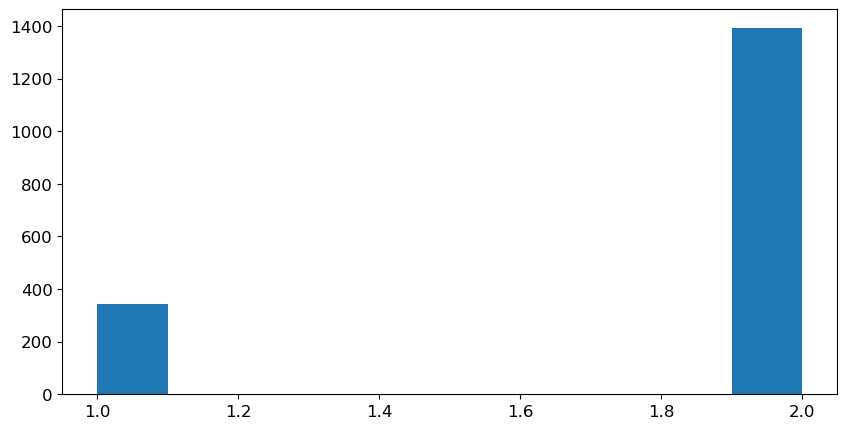

In [580]:
plt.hist(dist_agglo_cluster_matrix[:,-11])
plt.show()

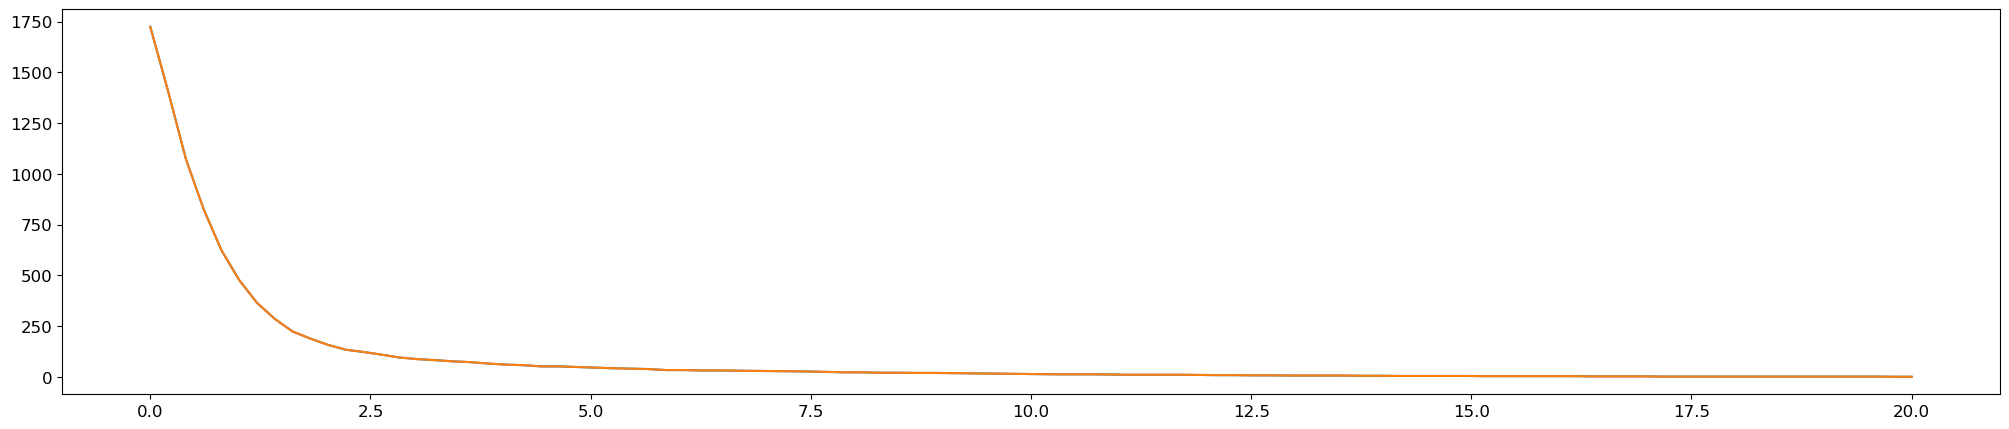

In [536]:
plt.plot(np.linspace(0,20,100), no_clusters)
plt.show()

In [ ]:
no_clusters = []
for distance in np.linspace(0,20,100):
    clusters = fcluster(linkage, distance, criterion='distance')

In [559]:
ob_state

{'20187-02-01-00': 'alpha',
 '20187-02-01-01': 'alpha',
 '20402-01-22-00': 'alpha',
 '20402-01-23-00': 'alpha',
 '20402-01-24-01': 'alpha',
 '20402-01-27-00': 'alpha',
 '20402-01-28-00': 'alpha',
 '20402-01-30-02': 'alpha',
 '10408-01-10-00': 'beta',
 '10408-01-21-00': 'beta',
 '20402-01-43-02': 'beta',
 '20402-01-44-00': 'beta',
 '20402-01-45-03': 'beta',
 '20402-01-46-00': 'beta',
 '20402-01-52-01': 'beta',
 '20402-01-52-02': 'beta',
 '20402-01-53-00': 'beta',
 '40703-01-18-00': 'beta',
 '40703-01-19-00': 'beta',
 '40703-01-19-01': 'beta',
 '40703-01-22-00': 'beta',
 '40703-01-22-01': 'beta',
 '40703-01-35-00': 'beta',
 '40703-01-35-01': 'beta',
 '20402-01-37-00': 'gamma',
 '20402-01-37-02': 'gamma',
 '20402-01-38-00': 'gamma',
 '20402-01-39-00': 'gamma',
 '20402-01-39-02': 'gamma',
 '20402-01-40-00': 'gamma',
 '20402-01-55-00': 'gamma',
 '20402-01-56-00': 'gamma',
 '20402-01-57-00': 'gamma',
 '40703-01-13-00': 'gamma',
 '40115-01-07-00': 'gamma',
 '40703-01-31-00': 'gamma',
 '10408-

In [558]:
np.unique(seg_ObIDs)

fcluster(linkage, 0, criterion='distance')

array([ 450,  438,  384, ...,  419,  534, 1702], dtype=int32)

In [540]:
np.unique(fcluster(linkage, 12.5, criterion='distance'))

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

weighted


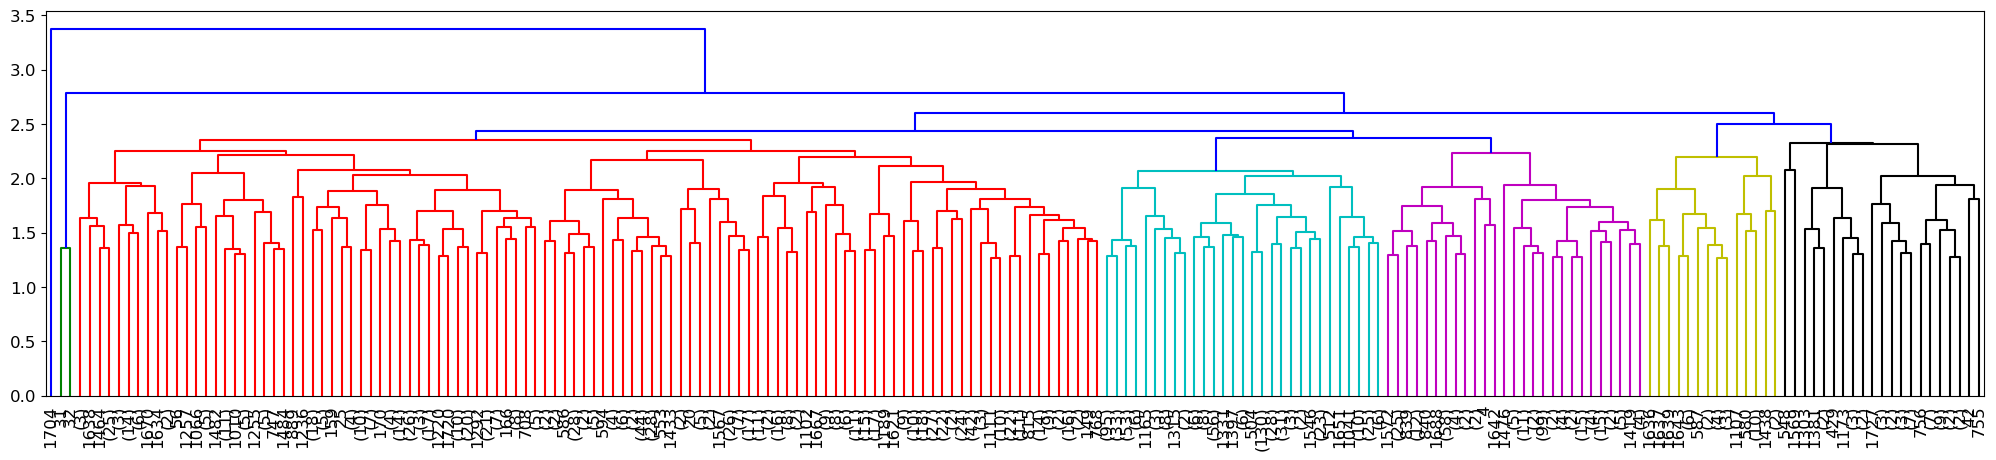

single


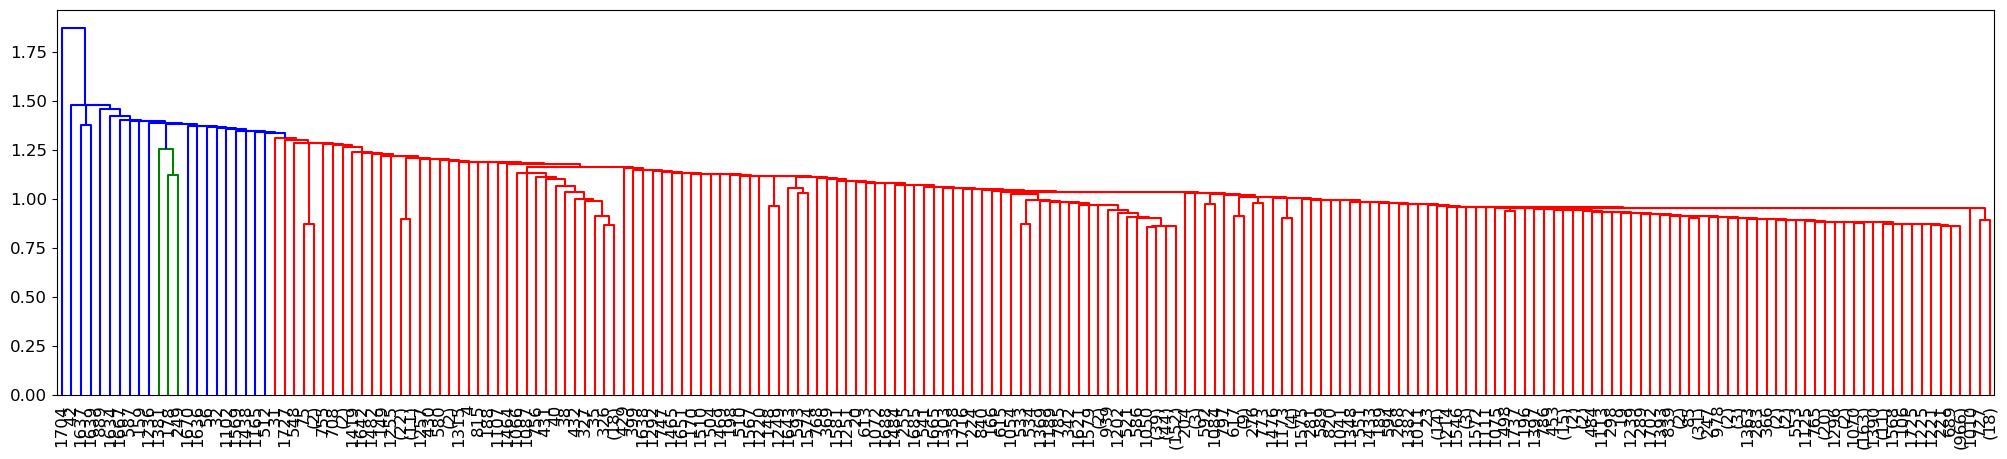

average


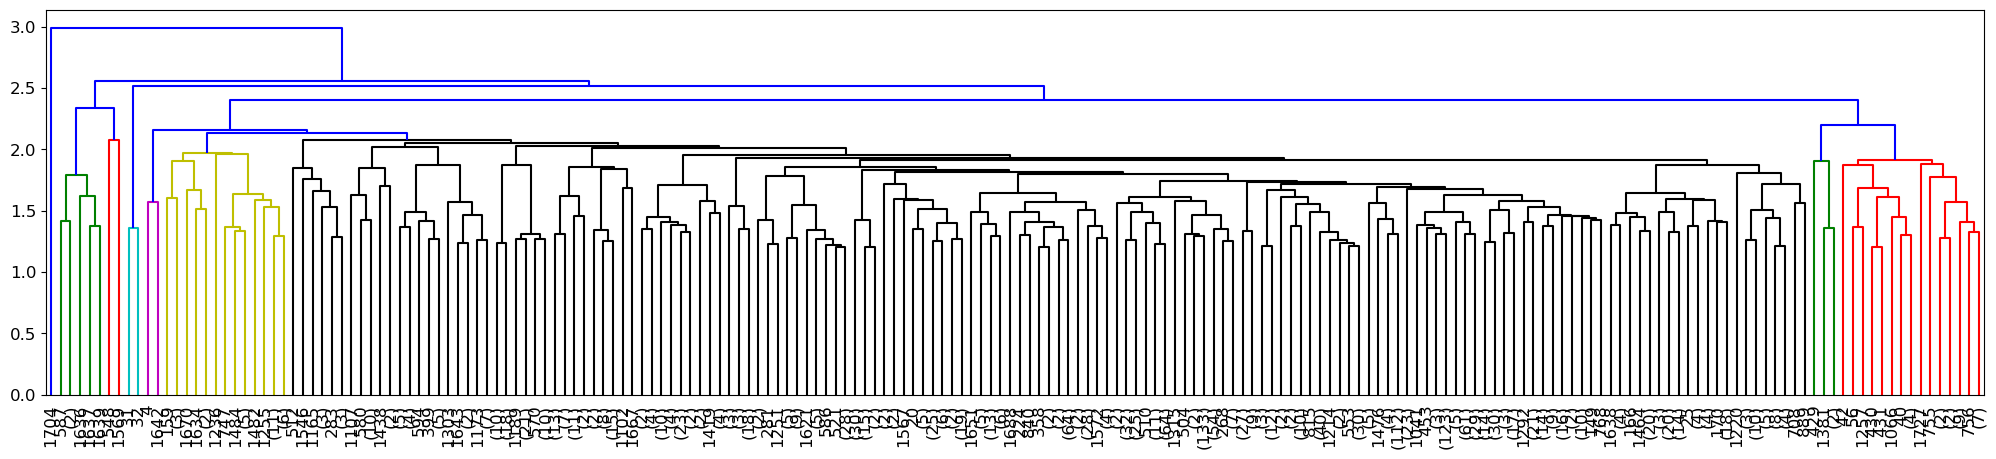

complete


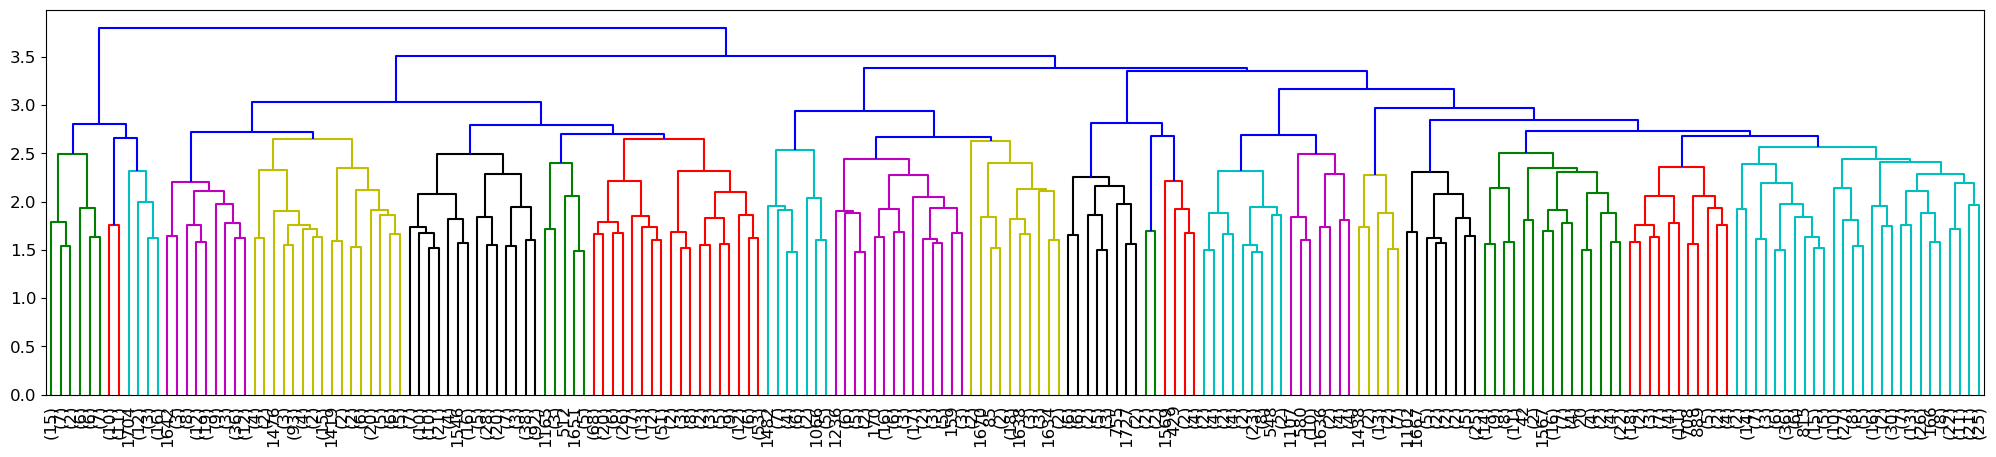

centroid


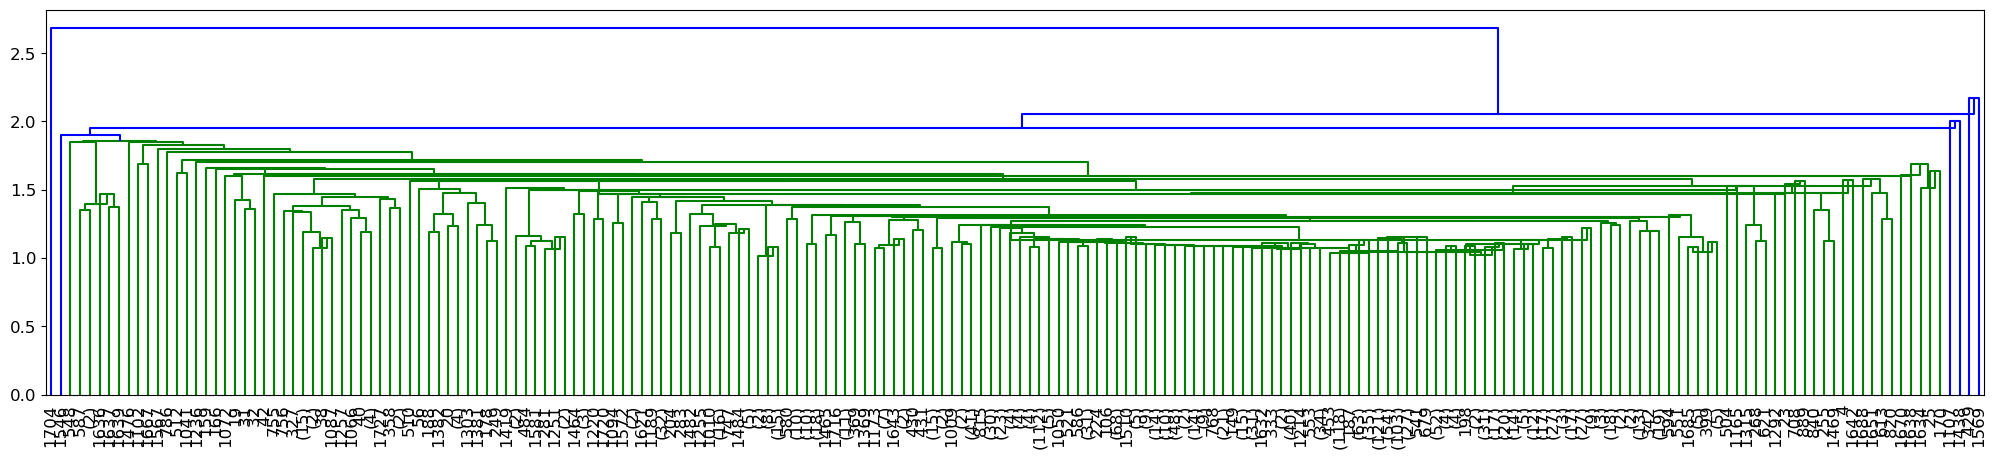

median


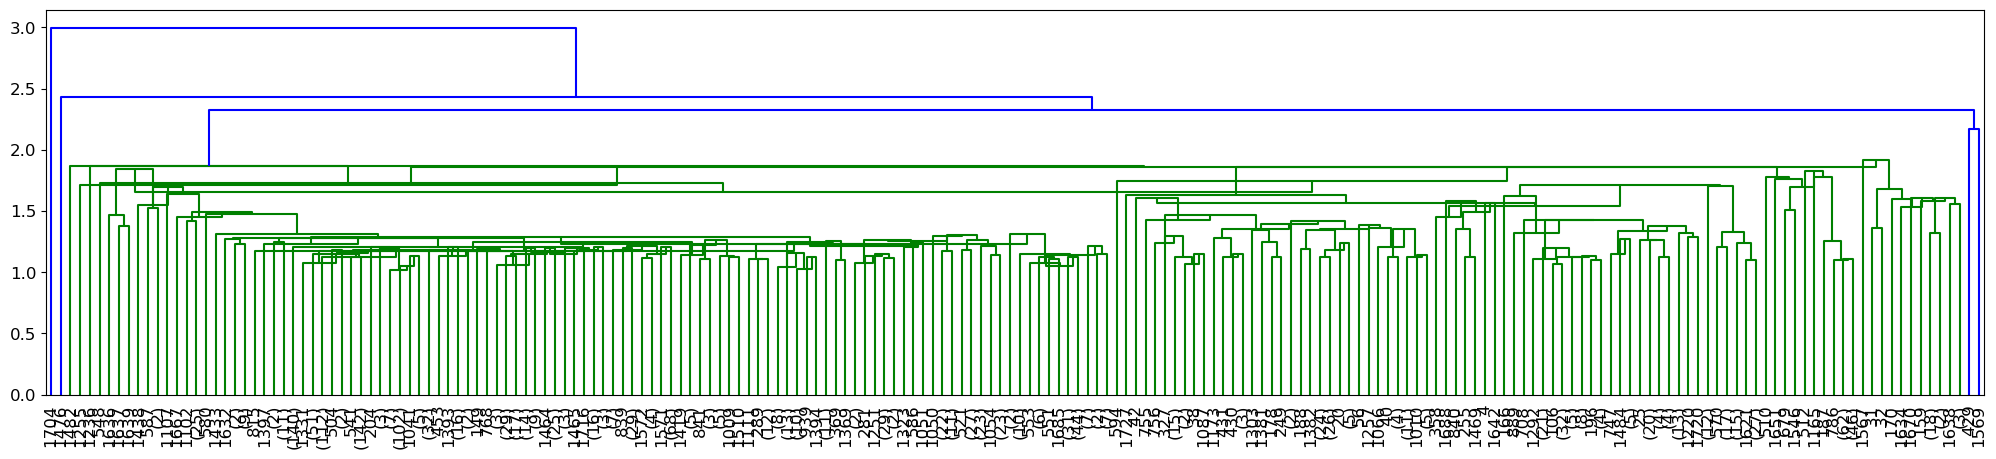

ward


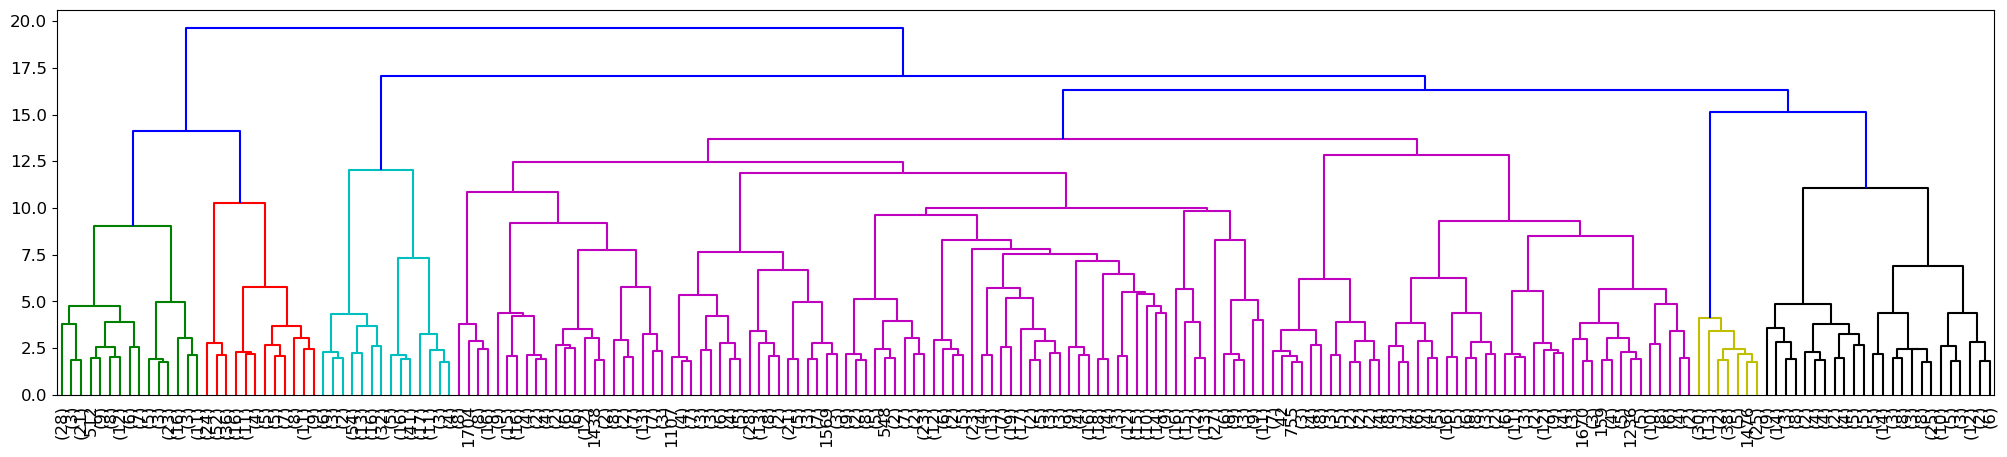

In [528]:
import scipy.cluster.hierarchy as sch
for method in ["weighted", "single", "average", "complete", "centroid", "median", "ward"]:
    linkage = sch.linkage(normalized_obs_component_counts_df, method=method)
    dendrogram = sch.dendrogram(linkage, truncate_mode="lastp", p=200, leaf_font_size = 12)
    print(method)
    plt.show()

# Visualisation of observations in the space of Gaussian component proportions

In [541]:
UMAP_mapper = umap.UMAP(verbose=True)#n_neighbors=50, min_dist=0.0, local_connectivity, repulsion_strength, negative_sample_rate
UMAP_mapper.fit(normalized_obs_component_counts_df)
umaped_data = UMAP_mapper.transform(normalized_obs_component_counts_df)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Mon Aug  3 18:36:06 2020 Finding Nearest Neighbors
Mon Aug  3 18:36:09 2020 Finished Nearest Neighbor Search
Mon Aug  3 18:36:12 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed

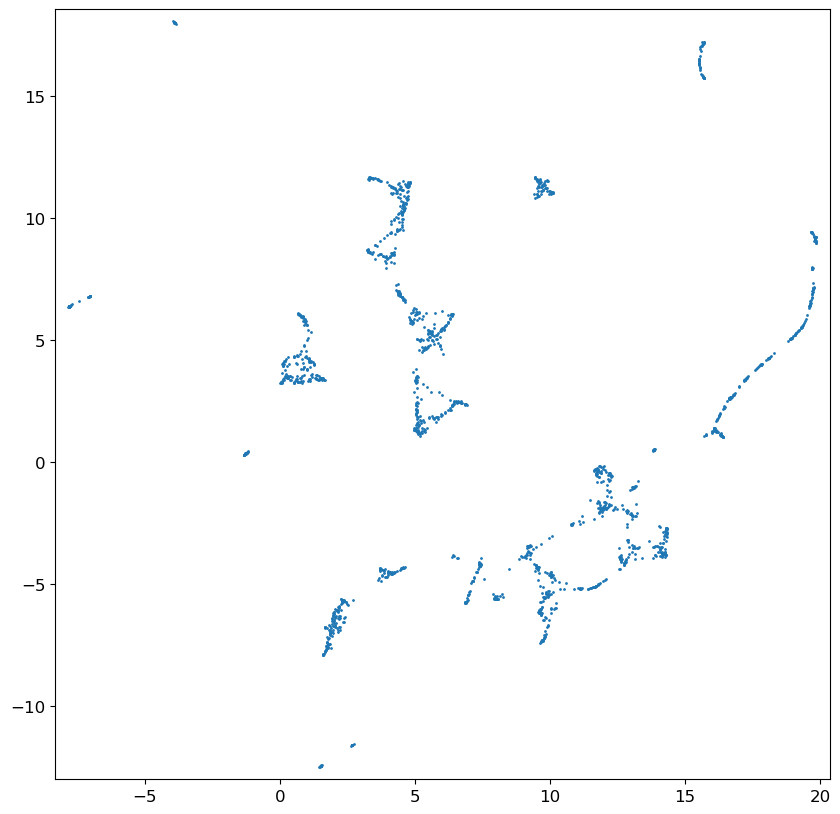

In [544]:
plt.rcParams['figure.figsize'] = [10,10]#(abs((np.min(umaped_data[:,0])-0.5) -(np.max(umaped_data[:,0])+0.5)), abs((np.min(umaped_data[:,1])-0.5)- (np.max(umaped_data[:,1])+0.5)))
plt.scatter(umaped_data[:,0], umaped_data[:,1], s=1)
plt.xlim([np.min(umaped_data[:,0])-0.5, np.max(umaped_data[:,0])+0.5])
plt.ylim([np.min(umaped_data[:,1])-0.5, np.max(umaped_data[:,1])+0.5])
plt.show()

In [545]:
from sklearn.decomposition import IncrementalPCA, PCA

n_components = None# segment_encoding.shape[-1]
# ipca = IncrementalPCA(n_components=n_components, batch_size=468202)
pca = PCA(n_components=n_components)

# X_ipca = ipca.fit(segment_encoding[:,0,:])
X_pca = pca.fit(normalized_obs_component_counts_df)

In [547]:
# X_transformed = X_ipca.transform(segment_encoding[:,0,:])
X_transformed = X_pca.transform(normalized_obs_component_counts_df)

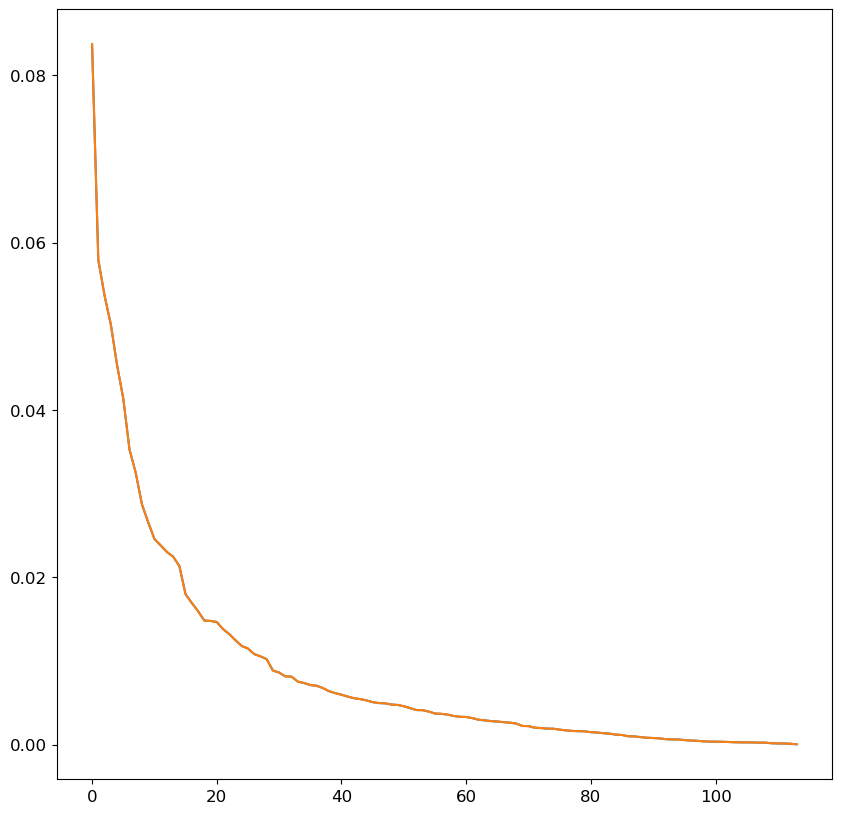

In [551]:
plt.plot(X_pca.explained_variance_ratio_)
plt.show()

# Classification based on Gaussian component proportions

In [614]:
compar_results = np.zeros((2,1))

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)


for test_iter in range(1):
    test_set = []
    train_set = []

    for class_name in ["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"]:

        class_obs_all = inv_ob_state[class_name]
        class_obs = []
        for ob in class_obs_all:
            if ob in seg_ObIDs:
                class_obs.append(ob)

        test_obs = np.random.choice(class_obs, size=int(np.ceil(len(class_obs)/3)))

        if len(test_obs) == 0:
            print(class_name)

        train_obs = []
        for ob in class_obs:
            if ob not in test_obs:
                train_obs.append(ob)
        test_set.append(test_obs)
        train_set.append(train_obs)
    #     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    #     test_set = np.random.choice(class_obs, size=)

    #     np.where(class_name == "class_name")
    test_set=np.hstack(test_set)
    train_set=np.hstack(train_set)

#     test_seg_ids=[]
#     train_seg_ids=[]

#     for ind_ob, ob in enumerate(xxx):
#         if ob in test_set:
#             test_seg_ids.append(ind_ob)
#         elif ob in train_set:
#             train_seg_ids.append(ind_ob)


#     SVC_clf = SVC(gamma="auto").fit(SAI_data[train_seg_ids], np.array(segment_class)[train_seg_ids])
#     SVC_clf_score = SVC_clf.score(SAI_data[test_seg_ids], np.array(segment_class)[test_seg_ids])
#     compar_results[0, test_iter] = SVC_clf_score


#     SVC_clf2 = SVC(gamma="auto").fit(shape_desc_GM[train_seg_ids], np.array(segment_class)[train_seg_ids])
#     SVC_clf2_score = SVC_clf2.score(shape_desc_GM[test_seg_ids], np.array(segment_class)[test_seg_ids])
#     compar_results[1, test_iter] = SVC_clf2_score
#     print(test_iter)

In [617]:
len(train_set)

149

Classification with proportional make up of observations in terms of 114 Gaussian mixture components
              precision    recall  f1-score   support

       alpha       1.00      0.67      0.80         3
        beta       1.00      1.00      1.00         5
         chi       0.96      0.96      0.96        26
       delta       0.62      1.00      0.76         8
         eta       0.00      0.00      0.00         1
       gamma       0.60      0.75      0.67         4
       kappa       1.00      1.00      1.00         4
      lambda       1.00      0.50      0.67         2
          mu       0.00      0.00      0.00         2
          nu       0.00      0.00      0.00         1
       omega       0.00      0.00      0.00         1
         phi       0.75      1.00      0.86         3
         rho       0.83      0.83      0.83         6
       theta       1.00      1.00      1.00         6

    accuracy                           0.86        72
   macro avg       0.63      0.62

/export/data/jakubok/software/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


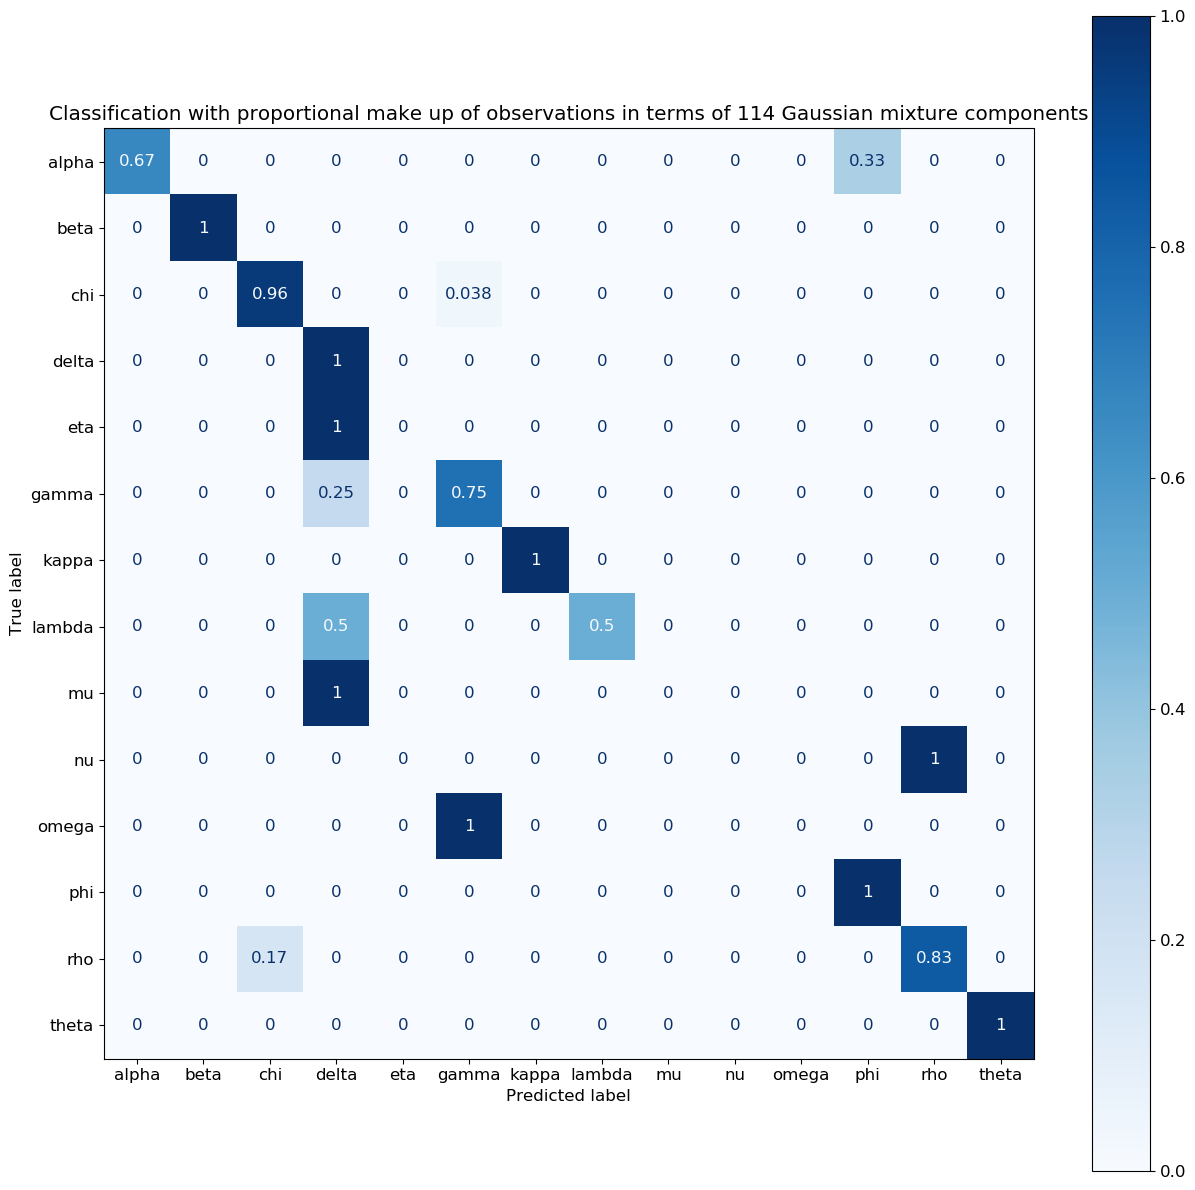

In [654]:
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix


plt.rcParams['figure.figsize'] = (15,15)

experiment_list = [

    [normalized_obs_component_counts_df, "Classification with proportional make up of observations in terms of 114 Gaussian mixture components"],

]



for dataset, title in experiment_list:
    SVC_clf = RandomForestClassifier(random_state=11).fit(dataset.loc[train_set].iloc[:,:114], dataset["Class"].loc[train_set])
    if title[-8:] == "balanced":
        SVC_clf = SVC(gamma="auto", class_weight="balanced").fit(dataset.loc[train_set].iloc[:,:114], dataset["Class"].loc[train_set])

    preds = SVC_clf.predict(dataset.loc[test_set].iloc[:,:114])
    print("{}".format(title))
    print(classification_report(dataset["Class"].loc[test_set], preds))
    
    
    
    disp = plot_confusion_matrix(SVC_clf, dataset.loc[test_set].iloc[:,:114], dataset["Class"].loc[test_set],
                             cmap=plt.cm.Blues,
                             normalize='true')
    disp.ax_.set_title("{}".format(title))
    plt.show()
    
    

In [635]:
dataset.loc[train_set].iloc[:,:114]

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
20187-02-01-00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.131737,0.0,...,0.0,0.0,0.023952,0.0,0.000000,0.095808,0.041916,0.0,0.000000,0.000000
20187-02-01-01,0.014493,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.086957,0.0,...,0.0,0.0,0.072464,0.0,0.014493,0.072464,0.050725,0.0,0.000000,0.007246
20402-01-23-00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.106383,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.148936
20402-01-27-00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.052632,0.0,0.052632,0.000000,0.052632,0.0,0.000000,0.000000
20402-01-30-02,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20402-01-26-01,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.026316,0.000000
20402-01-48-00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
80127-01-02-01,0.000000,0.511628,0.0,0.0,0.0,0.0,0.000000,0.0,0.209302,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
40703-01-27-00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.136986,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [631]:
dataset["Class"].loc[train_set]

20187-02-01-00    alpha
20187-02-01-01    alpha
20402-01-23-00    alpha
20402-01-27-00    alpha
20402-01-30-02    alpha
                  ...  
20402-01-26-01      chi
20402-01-48-00      chi
80127-01-02-01      eta
40703-01-27-00    omega
40703-01-29-01    omega
Name: Class, Length: 149, dtype: object

In [630]:
normalized_obs_component_counts_df

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,Class
10258-01-01-00,0.0,0.0,0.0,0.115023,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009390,Unknown
10258-01-02-00,0.0,0.0,0.0,0.175355,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014218,Unknown
10258-01-03-00,0.0,0.0,0.0,0.089445,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Unknown
10258-01-04-00,0.0,0.0,0.0,0.017380,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001337,Unknown
10258-01-05-00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96701-01-50-01,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Unknown
96701-01-51-00,0.0,0.0,0.0,0.026316,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Unknown
96701-01-51-01,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Unknown
96701-01-52-00,0.0,0.0,0.0,0.274194,0.0,0.000000,0.0,0.016129,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Unknown


In [626]:
obs_classes

['Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'lambda',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'mu',
 'beta',
 'phi',
 'phi',
 'Unknown',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'delta',
 'theta',
 'theta',
 'theta',
 'theta',
 'theta',
 'theta',
 'theta',
 'theta',
 'theta',
 'theta',
 'delta',
 'phi',
 'phi',
 'delta',
 'Unknown',
 'delta',
 'delta',
 'phi',
 'phi',
 'phi',
 'phi',
 'phi',
 'beta',
 'Unknown',
 'Unknown',
 'chi',
 'chi',
 'Unknown',
 'chi',
 'chi',
 'chi',
 'chi',
 'chi',
 'chi',
 'chi',
 'chi',
 'chi',
 'chi',
 'mu',
 'mu',
 'mu',
 'Unknown',
 'Unknown',
 'nu',
 'nu',
 'chi',
 'chi',
 'nu',
 'chi',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'theta',
 'Unknown',
 'theta',
 'Unknown',
 'theta',
 'Unknown',
 'theta',
 'chi',
 'Unknown',
 'Unknown',
 'Unknown',
 'chi',
 'Unknown',
